In [2]:
import meshio
import open3d as o3d
import copy
import numpy as np
from matplotlib import pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Check ray sampling

In [10]:
rays = np.loadtxt("./dataset/spot/rays.dat")

num_steps = 128
rays_o, rays_d, tmin, tmax = rays[:, :3], rays[:, 3:6], rays[:, 6:7], rays[:, 7:8]

step_size = (tmax - tmin) / num_steps

rays_o = rays_o + rays_d * step_size
rays_info = np.hstack([rays_o, rays_d])
head_line= "NumRays= %d\nx y z dx dy dz" %(len(rays_o))
np.savetxt("./spot/rayinfo.dat", rays_info, header=head_line, delimiter=" ", fmt="%s",comments="")

Load NGP mesh:  (2438170, 3) (4941120, 3)
(640000, 3) (640000, 3) (640000, 1) (640000, 1) (640000, 4)
(640000, 128, 1)
(640000, 128, 3)
(800, 800, 6)
dict_keys(['t_hit', 'geometry_ids', 'primitive_ids', 'primitive_normals', 'primitive_uvs'])


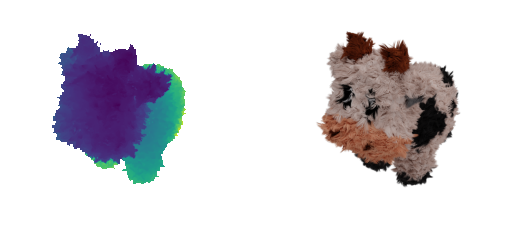

In [9]:
########## check ray sampling ##########
mesh_ngp    = o3d.io.read_triangle_mesh("../dataset/spot/spot_ngp.obj")
print("Load NGP mesh: ", np.asarray(mesh_ngp.vertices).shape, np.asarray(mesh_ngp.triangles).shape)
mesh_offset = meshio.read("../dataset/spot/spots_ngp_coord.msh")

tet_offset = o3d.geometry.TetraMesh(
        o3d.utility.Vector3dVector((mesh_offset.points)), 
        o3d.utility.Vector4iVector(mesh_offset.cells_dict['tetra']))

o3d.visualization.draw_geometries([mesh_ngp, tet_offset])

rays = np.loadtxt("../dataset/spot/rays.dat")
rays_o, rays_d, tmin, tmax = rays[:, :3], rays[:, 3:6], rays[:, 6:7], rays[:, 7:8]
ray_color = rays[:, 8:]
print(rays_o.shape, rays_d.shape, tmin.shape, tmax.shape, ray_color.shape)

steps = 128
sampling_dt = np.linspace(0., 1., steps)[None]
sampling_dt = (tmin + sampling_dt * (tmax - tmin))[:, :, None]
print(sampling_dt.shape)

sampling_pts = rays_o[:, None, :] + rays_d[:, None, :]*sampling_dt
print(sampling_pts.shape)

sub_ray_idx = np.random.randint(len(rays_o), size=5000)
sub_ptx_idx = np.random.randint(steps, size=3)
sub_sampling_pts = sampling_pts[sub_ray_idx][:, sub_ptx_idx, :]
pc_ray = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(sub_sampling_pts.reshape(-1, 3)))
pc_ray.colors = o3d.utility.Vector3dVector(np.repeat(ray_color[sub_ray_idx, None, :3], 3, axis=1).reshape(-1, 3))

o3d.visualization.draw_geometries([mesh_ngp, pc_ray])

########## check ray sampling ##########
scene = o3d.t.geometry.RaycastingScene()
scene.add_triangles(o3d.t.geometry.TriangleMesh.from_legacy(mesh_ngp))
rays_frame = rays[:, :6].reshape(800, 800, 6)
print(rays_frame.shape)

# Compute the ray intersections.
ans = scene.cast_rays(rays_frame.astype(np.float32))
print(ans.keys())
# Visualize the hit distance (depth)
gt_vis = rays[:, 8:].reshape(800, 800, 4)

plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(ans['t_hit'].numpy())
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(gt_vis)



In [25]:
print(sampling_pts.reshape(-1, 3).max(axis=0), sampling_pts.reshape(-1, 3).min(axis=0))
pts_ngp = sampling_pts*0.33 + 0.5
print(pts_ngp.reshape(-1, 3).max(axis=0), pts_ngp.reshape(-1, 3).min(axis=0))


[2.0735578 2.0220686 5.949167 ] [-7.19642  -6.630007 -1.678193]
[1.18427407 1.16728264 2.46322511] [-1.8748186  -1.68790231 -0.05380369]


In [4]:
print(sampling_pts.shape)

(640000, 128, 3)


In [42]:
import pyngp as ngp
snapshot_fp = "./1/spot.msgpack"
testbed = ngp.Testbed(ngp.TestbedMode.Nerf)
testbed.load_snapshot(snapshot_fp)

pts_pos = (sampling_pts*0.33 + 0.5).reshape(-1, 3)
pts_dirs = (rays_d[:, None, :].repeat(sampling_pts.shape[1], 1)).reshape(-1, 3)
pts_mask = np.all(pts_pos>=0, axis=1) & (np.sum(pts_pos, axis=1)<=1)

pts_rgb = testbed.get_rgba_by_points_to_cpu(
    (pts_pos[pts_mask, :].T)[:, :1024], (pts_dirs[pts_mask, :].T)[:, :1024], True)
print(pts_rgb)
pts_rgb = np.asarray(pts_rgb)
print(pts_rgb.shape)




In [39]:
pts_rgb = testbed.get_rgba_by_points_to_cpu(
    (pts_pos[pts_mask, :].T)[:, :128], (pts_dirs[pts_mask, :].T)[:, :128], True)
pts_rgb = np.asarray(pts_rgb)
print(pts_rgb.shape)


(16384, 4)


In [35]:
print(pts_pos.shape, pts_dirs.shape, pts_mask.shape)


(81920000, 3) (640000, 128, 3) (81920000,)


# Load Mesh

In [ ]:
print("NGP: ")
mesh_ngp = meshio.read("./0/spot_ngp.obj")
print(mesh_ngp.points.shape, mesh_ngp.cells_dict['triangle'].shape)
print(mesh_ngp.points[:, :3].max(axis=0), mesh_ngp.points[:, :3].min(axis=0))

print("Base: ")
mesh_base = meshio.read("./0/base.obj")
print(mesh_base.points.shape, mesh_base.cells_dict['triangle'].shape)
print(mesh_base.points.max(axis=0), mesh_base.points.min(axis=0))
tetra_base = meshio.read("./0/spot_base_tetwild.msh")
print(tetra_base.points.shape, tetra_base.cells_dict['tetra'].shape)
print(tetra_base.points.max(axis=0), tetra_base.points.min(axis=0))

print("Offset: ")
mesh_offset = meshio.read("./0/offset.obj")
print(mesh_offset.points.shape, mesh_offset.cells_dict['triangle'].shape)
print(mesh_offset.points.max(axis=0), mesh_offset.points.min(axis=0))
tetra_offset = meshio.read("./0/spot_offset_tetwild.msh")
print(tetra_offset.points.shape, tetra_offset.cells_dict['tetra'].shape)
print(tetra_offset.points.max(axis=0), tetra_offset.points.min(axis=0))

# transform mesh

In [ ]:
trans_init = np.asarray([
    [-0.0294111, 0.9994, 0.0182936, 0.0], 
    [0.000939915, -0.0182739, 0.999833, 0.0],
    [0.999567, 0.0294233, -0.000401901, 0.0], 
    [0.0, 0.0, 0.0, 1.0]])


def transform_tet_mesh(mesh_fp, trans):
    tet_mesh = meshio.read(mesh_fp)
    pc = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(tet_mesh.points[:, :3]))
    pc.transform(trans)
    tet_mesh.points[:, :3] = np.asarray(pc.points)
    tet_mesh.write(mesh_fp)    

transform_tet_mesh("./0/offset.obj", trans_init)

# Simplification

In [ ]:
def draw_tetra_mesh(verts, tetras):
    tet_mesh = o3d.geometry.TetraMesh(
        o3d.utility.Vector3dVector(verts), 
        o3d.utility.Vector4iVector(tetras))
    o3d.visualization.draw_geometries([tet_mesh])

def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud],
                                      zoom=0.3412,
                                      front=[0.4257, -0.2125, -0.8795],
                                      lookat=[2.6172, 2.0475, 1.532],
                                      up=[-0.0694, -0.9768, 0.2024])



# Registration

In [ ]:
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp],
                                      zoom=0.4459,
                                      front=[0.9288, -0.2951, -0.2242],
                                      lookat=[1.6784, 2.0612, 1.4451],
                                      up=[-0.3402, -0.9189, -0.1996])

def preprocess_point_cloud(pcd, voxel_size=-1):
    
    pcd_down = pcd.voxel_down_sample(voxel_size) if voxel_size > 0 else copy.deepcopy(pcd)
    print(":: Downsample with a voxel size %.3f." % voxel_size, np.asarray(pcd_down.points).shape)

    radius_normal = voxel_size * 2
    print(":: Estimate normal with search radius %.3f." % radius_normal)
    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    radius_feature = voxel_size * 5
    print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    return pcd_down, pcd_fpfh

                                      
def execute_global_registration(source_down, target_down, source_fpfh,
                                target_fpfh, voxel_size):
    distance_threshold = voxel_size * 1.5
    print(":: RANSAC registration on downsampled point clouds.")
    print("   Since the downsampling voxel size is %.3f," % voxel_size)
    print("   we use a liberal distance threshold %.3f." % distance_threshold)
    result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh, True,
        distance_threshold,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
        3, [
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(
                0.9),
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(
                distance_threshold)
        ], o3d.pipelines.registration.RANSACConvergenceCriteria(100000, 0.999))
    return result
    
def refine_registration(source, target, source_fpfh, target_fpfh, voxel_size, coarse_trans):
    distance_threshold = voxel_size * 0.4
    print(":: Point-to-plane ICP registration is applied on original point")
    print("   clouds to refine the alignment. This time we use a strict")
    print("   distance threshold %.3f." % distance_threshold)
    result = o3d.pipelines.registration.registration_icp(
        source, target, distance_threshold, coarse_trans,
        o3d.pipelines.registration.TransformationEstimationPointToPlane())
    return result


In [ ]:
ngp_verts = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(mesh_ngp.points[:, :3]))
cl, ind = ngp_verts.remove_statistical_outlier(nb_neighbors=100, std_ratio=2.0)
# display_inlier_outlier(ngp_verts, ind)
ngp_verts = ngp_verts.select_by_index(ind)
ngp_verts = ngp_verts.voxel_down_sample(0.055)
bbox = ngp_verts.get_axis_aligned_bounding_box()
print('NGP mesh downsampling:', np.asarray(ngp_verts.points).shape)
print('BBoox: ', bbox)

base_verts = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(tetra_offset.points[:, :3]))
print('Base tetra:', np.asarray(ngp_verts.points).shape)

draw_registration_result(ngp_verts, base_verts, np.identity(4))

# voxel_size = 0.01
# trans_init = np.asarray([
#     [-0.0294111, 0.9994, 0.0182936, 0.0], 
#     [0.000939915, -0.0182739, 0.999833, 0.0],
#     [0.999567, 0.0294233, -0.000401901, 0.0], 
#     [0.0, 0.0, 0.0, 1.0]])

# source, source_fpfh = preprocess_point_cloud(base_verts, voxel_size)
# source.transform(trans_init)
# trgt, trgt_fpfh = preprocess_point_cloud(ngp_verts, voxel_size)

# draw_registration_result(source, trgt, np.identity(4))

# result_ransac = execute_global_registration(source, trgt, 
#                                             source_fpfh, trgt_fpfh, 
#                                             voxel_size)
# print(result_ransac)
# draw_registration_result(source, trgt, result_ransac.transformation)

# result_icp = refine_registration(source, trgt, source_fpfh, trgt_fpfh, 
#                                  voxel_size, result_ransac.transformation)
# print(result_icp)
# draw_registration_result(source, trgt, result_icp.transformation)



In [ ]:
import open3d as o3d

mesh = meshio.read("spot_ngp_tetwild.msh")
print(mesh.points.shape, mesh.cells_dict['tetra'].shape)
print(mesh.points.max(axis=0), mesh.points.min(axis=0))


In [ ]:
mesh = meshio.read("./1/spot_offset_tetwild.msh")
verts = mesh.points
tetras = mesh.cells_dict['tetra']

with open("./1/verts.dat", "w") as f:
    f.write("NumTetVerts= %d\n"%(len(mesh.points)))
    f.write("x y z\n")
    for i in range(len(mesh.points)):
        f.write("%s\n"%(" ".join([f"{x:.6f}" for x in verts[i]])))

print("DONE: verts.dat")

with open("./1/cells.dat", "w") as f:
    f.write("NumTetCells= %d\n"%(len(mesh.cells_dict['tetra'])))
    f.write("id1 id2 id3 id4\n")
    for i in range(len(mesh.cells_dict['tetra'])):
        f.write("%s\n"%(" ".join([str(x) for x in tetras[i]])))
print("DONE: cells.dat")
